## Imports


In [1]:
import json
import os
import pandas as pd
import tensorflow as tf
import numpy as np
import time as t

from preprocessing import normalize, process, resample
from plot import plot_predictions_with_null
from model import create_model, MultiScaleResidualBlock

2023-09-15 13:01:18.228984: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-15 13:01:18.254735: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-15 13:01:18.590842: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Constants

In [2]:
# small_fortune = 100.79655493
small_fortune = 100
FEE_MODIFIER = 1 - 0.01 * 0.1

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

ready_model_path = "./results/20230914-210004"
main_loop_params_file = os.path.join(ready_model_path, 'params/params.json')
technical_indicators_file = os.path.join(ready_model_path, 'params/indicators.json')
normalization_file = os.path.join(ready_model_path, 'normalization/normalization.json')
model_file = os.path.join(ready_model_path, 'model/model.h5')

with open(main_loop_params_file, 'r') as file:
    params = json.load(file)
with open(technical_indicators_file, 'r') as f:
    indicator_config = json.load(f)

filename = "./data/eth_new.csv"
interval = params['interval']
modifier = params['modifier']
window_size = params['window_size']
nr_of_labels = params['nr_of_labels']
num_features = params['num_features']
batch_size = params['batch_size']

model = tf.keras.models.load_model(model_file, custom_objects={"MultiScaleResidualBlock": MultiScaleResidualBlock})
# 
# model = create_model(window_size, num_features, bidirectional=True, filter_size=16, l2_reg=0.01, external_filter_size=32, nr_of_labels=nr_of_labels, gru=False)
# 
# model.load_weights(model_file)
# 
# optimizer = tf.keras.optimizers.Adam(
    # learning_rate=0.00006
# )
# 
# loss = tf.keras.losses.BinaryCrossentropy()
# 
# model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'], run_eagerly=True)

technical_indicators = []
for indicator, enabled in indicator_config.items():
    if enabled:
        technical_indicators.append(indicator)

2023-09-15 13:01:19.210417: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-15 13:01:19.225703: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-15 13:01:19.225990: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

## Preprocessing

In [3]:
data = pd.read_csv(filename)
data = resample(data, interval)
close_data = data['close']
data = process(data, modifier, technical_indicators)
plot_data = data[['close', 'long']]
plot_data['clear_close'] = close_data
data = normalize(data, technical_indicators, normalization_file)
data.drop(columns=['unix', 'close'], inplace=True)

/tmp/ipykernel_35298/400449999.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_data['clear_close'] = close_data


In [4]:
num_samples = len(data) - window_size + 1

dataset = tf.data.Dataset.from_tensor_slices(data)
dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
dataset = dataset.map(lambda window: (window[:-1, :-nr_of_labels], tf.squeeze(window[-1:, -nr_of_labels:])))

train_size = int(0.8 * num_samples)
validation_size = int(0.1 * num_samples)
test_size = int(0.1 * num_samples)

train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size).take(validation_size)
test_dataset = dataset.skip(train_size).skip(validation_size)

# test_dataset = test_dataset.shuffle(test_size, reshuffle_each_iteration=True)

## Evaluation

In [5]:
# test_loss, test_accuracy = model.evaluate(dataset.batch(batch_size))

test_input_data = np.array([data[0] for data in dataset])
test_labels = np.array([data[1] for data in dataset])

predictions = model.predict(test_input_data[:-16])

2023-09-15 13:01:20.248218: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [17856,10]
	 [[{{node Placeholder/_0}}]]
2023-09-15 13:01:20.248316: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [17856,10]
	 [[{{node Placeholder/_0}}]]
2023-09-15 13:01:23.106512: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/spl

 15/553 [..............................] - ETA: 4s

2023-09-15 13:01:24.000453: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-09-15 13:01:24.092050: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


553/553 [==============================] - 5s 7ms/step


In [7]:
predicted_labels = np.argmax(predictions, axis=1)

assert len(close_data) - window_size == len(predicted_labels)
data = pd.DataFrame(predicted_labels, index=close_data.index[window_size:], columns=['prediction'])
data['long_prediction'] = predictions[:, 0]
data['short_prediction'] = predictions[:, 1]
data['close'] = close_data[window_size:]
value_change = data['close'].pct_change() + 1
data['transaction'] = data['prediction'].astype(bool)
data['transaction'] = data['transaction'] ^ data['transaction'].shift(fill_value=True)
data['transaction'].iloc[-1] = True
# data['small_fortune'] = np.nan
data['small_fortune'] = small_fortune

bought = False
for i in range(1, len(data)):
    data['small_fortune'][i] = data['small_fortune'][i - 1] * (value_change[i] if bought else 1)
    if data['transaction'][i]:
        data['small_fortune'][i] *= FEE_MODIFIER
        bought = not data['prediction'][i]

if data['small_fortune'][-1] > small_fortune:
    print('''$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$''')
print(data['small_fortune'][-1] / data['small_fortune'][0])

/tmp/ipykernel_35298/777266513.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['transaction'].iloc[-1] = True
/tmp/ipykernel_35298/777266513.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['small_fortune'][i] = data['small_fortune'][i - 1] * (value_change[i] if bought else 1)
/tmp/ipykernel_35298/777266513.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['small_fortune'][i] = data['small_fortune'][i - 1] * 

0.03930426376737921


/home/kmajchrzak/Desktop/scpxd/plot.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_data['predicted_null'] = np.any(predictions > null_threshold, axis=1)
/home/kmajchrzak/Desktop/scpxd/plot.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_data['predicted_short'] = predicted_labels.astype(bool)
/home/kmajchrzak/Desktop/scpxd/plot.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

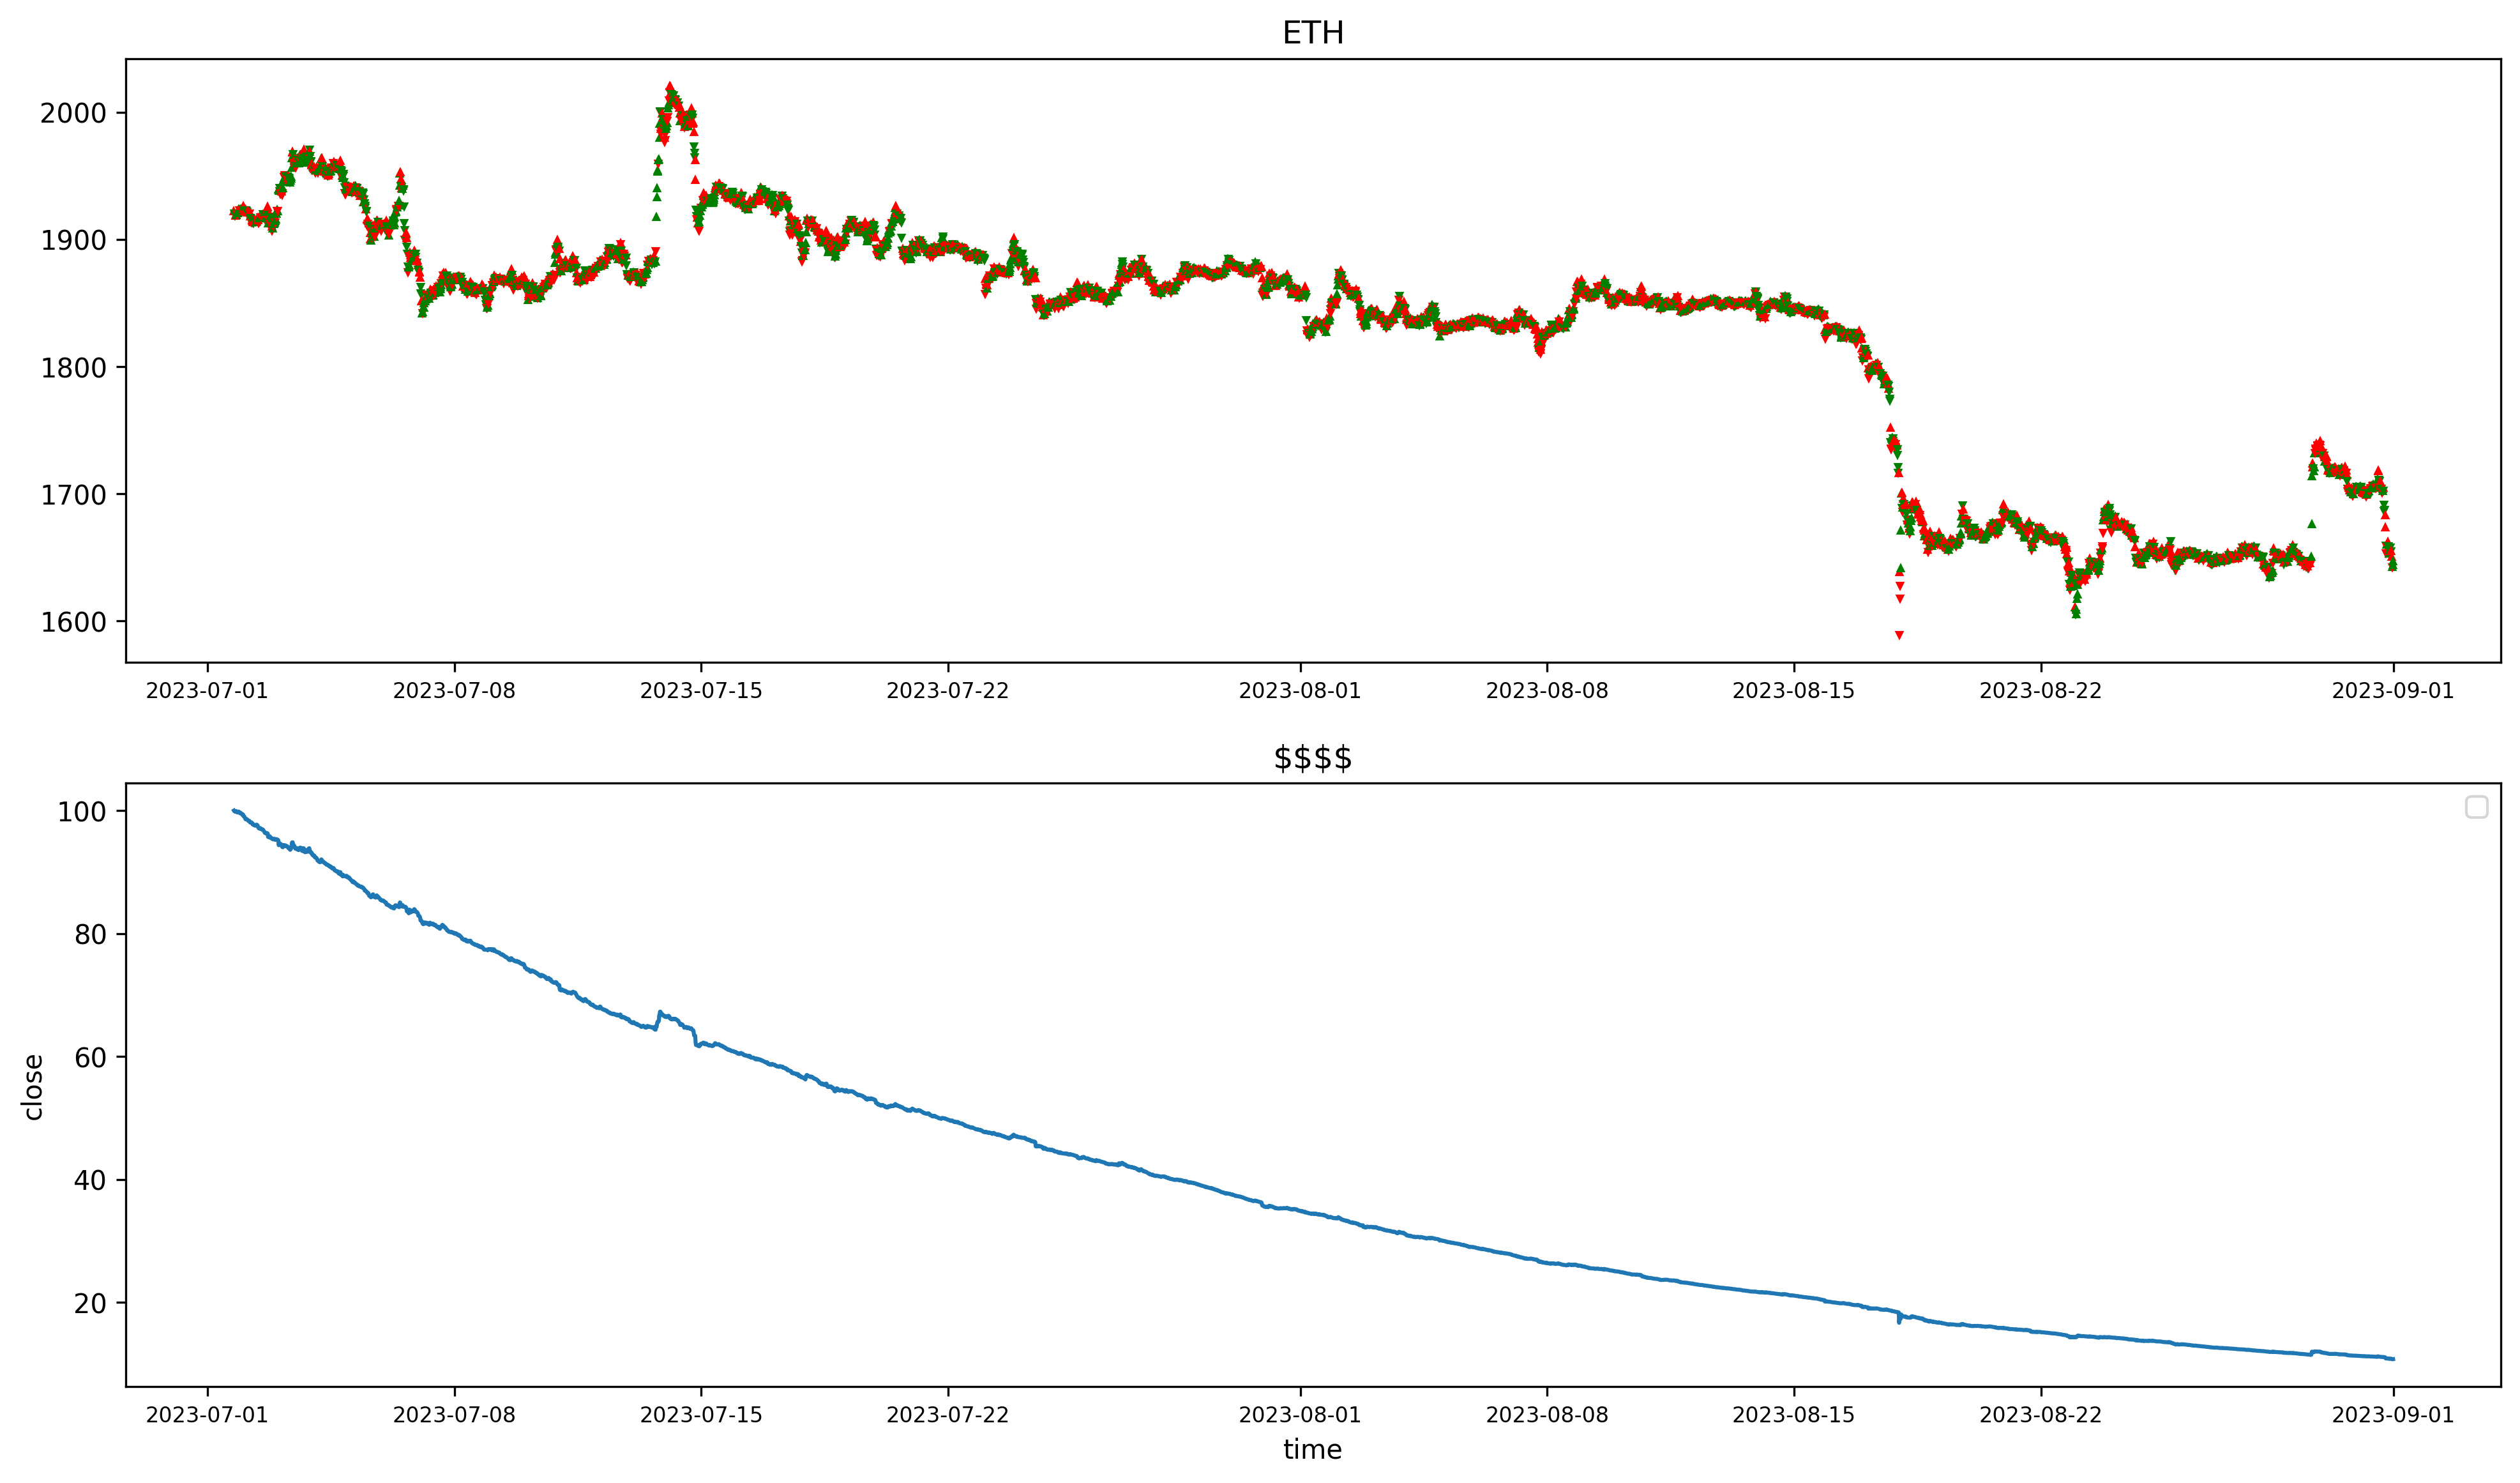

In [ ]:
plot_data['small_fortune'] = data['small_fortune']
plot_data['small_fortune'] = plot_data['small_fortune'].fillna(method='bfill')
plot_predictions_with_null(plot_data, predictions)#, .845)

In [17]:
predicted_labels = np.argmax(predictions, axis=1)

null_thresholds = [0.66]
# null_thresholds = np.linspace(.5, 1, 110)
dd = pd.DataFrame()

for null_threshold in null_thresholds:
    # assert len(close_data) - window_size == len(predicted_labels)
    data = pd.DataFrame(predicted_labels, index=close_data.index[window_size:-16], columns=['prediction'])
    data['long_prediction'] = predictions[:, 0]
    data['short_prediction'] = predictions[:, 1]
    data['close'] = close_data[window_size:]
    value_change = data['close'].pct_change() + 1
    data['over_threshold'] = np.any(predictions > null_threshold, axis=1)
    data['small_fortune'] = small_fortune

    bought = not data['prediction'][0]
    for i in range(1, len(data)):
        data['small_fortune'][i] = data['small_fortune'][i - 1] * (value_change[i] if bought else 1)
        if data['prediction'][i]:
            # short
            if bought and data['over_threshold'][i]:
                data['small_fortune'][i] *= 1 - 0.01 * 0.
                bought = False
        else:
            # long
            if not bought and data['over_threshold'][i]:
                data['small_fortune'][i] *= 1 - 0.01 * 0.
                bought = True

    if data['small_fortune'][-1] > small_fortune:
        print('''$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
    $$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
    $$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
    $$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$''')
    print('Wynik:', data['small_fortune'][-1] / data['small_fortune'][0], null_threshold)
    dd = pd.concat([dd, pd.DataFrame({'$': data['small_fortune'][-1] / data['small_fortune'][0]}, index=[null_threshold])])
print(dd[dd['$'] == np.max(dd['$'])])

/tmp/ipykernel_35298/1131874459.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['small_fortune'][i] = data['small_fortune'][i - 1] * (value_change[i] if bought else 1)


Wynik: 0.9077725128376359 0.66
             $
0.66  0.907773


In [9]:
# dd[dd['$']>1]

,$


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


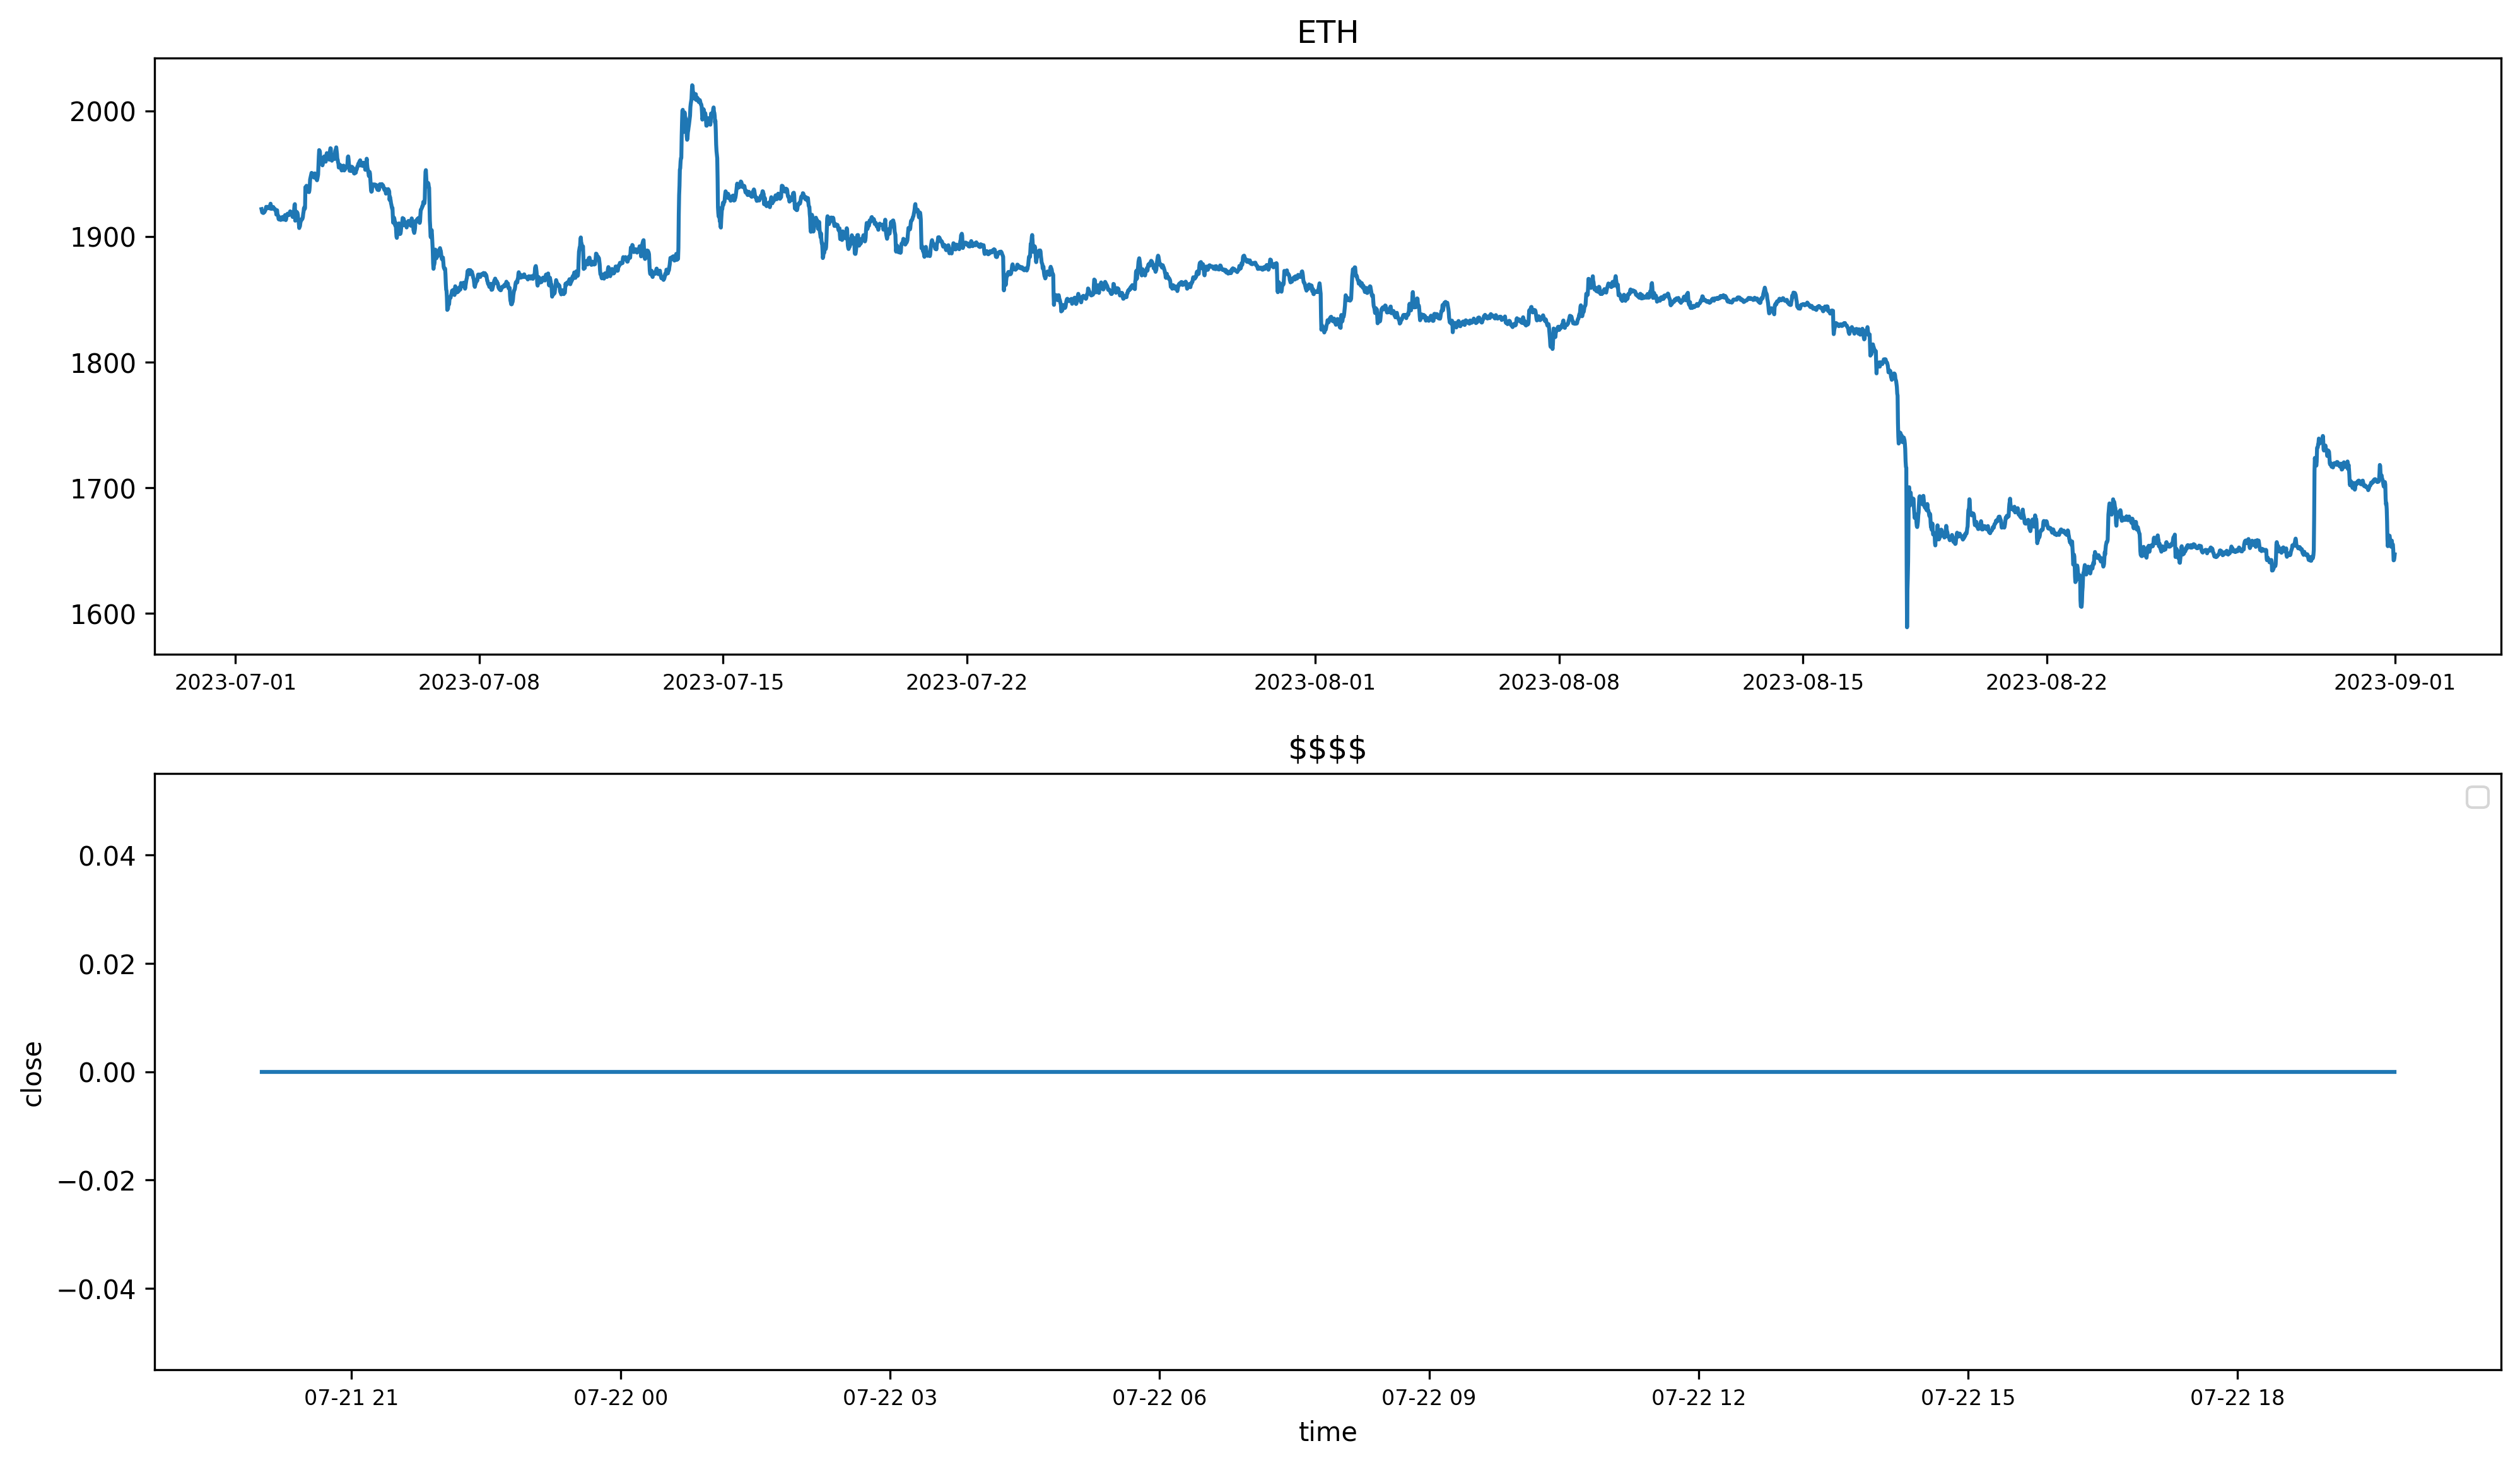

In [ ]:
import matplotlib.pyplot as plt

null_threshold = .45
predicted_labels = np.argmax(predictions, axis=1)

plot_data = plot_data[(plot_data.shape[0] - predictions.shape[0]):]
plot_data['predicted_null'] = np.any(predictions > null_threshold, axis=1)
plot_data['predicted_short'] = predicted_labels.astype(bool)
plot_data['predicted_long'] = ~plot_data['predicted_short']
plot_data['predicted_null'] = ~plot_data['predicted_null']

plot_data['gained'] = plot_data['small_fortune'].diff().apply(lambda row: 'g' if row > 0 else ('y' if row == 0 else 'r'))

# Create a line plot with colors based on the 'color' column
colors = {1: 'r', 0: 'g', 3: 'y', 2: 'm'}
markers = {True: '^', False: 'v', None: 'o'}

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

# for index, row in plot_data.iterrows():
    # ax1.plot(index, row['close'], ls='-', lw=0.1, marker=markers[None if row['predicted_null'] else row['predicted_long']],
                # markersize=2, c=colors[2 * int(row['predicted_null']) + int(bool(row['long']) ^ row['predicted_long'])])

ax1.tick_params('x', labelsize=8)
ax1.set_title('ETH')

df = pd.read_csv(filename)
df = resample(df, interval)[2000:2096]
df = process(df, modifier, technical_indicators)
df = normalize(df, technical_indicators, normalization_file)

ax1.plot(plot_data.index, plot_data['close'])
ax2.plot(plot_data.index, df['close'] - plot_data['close'])
ax2.tick_params('x', labelsize=8)
ax2.set_title('$$$$')

# fig = plt.gcf()  # Get the current figure
fig.patch.set_facecolor('white')
fig.set_size_inches(16, 9)  # Set the figure size in inches (16:9 aspect ratio)
fig.set_dpi(300)

# Set plot title, labels, and legend
plt.title('\$\$\$\$')
plt.xlabel('time')
plt.ylabel('close')
plt.legend()

# Display the plot
plt.show()
# input()

In [ ]:
predicted_labels = np.argmax(predictions, axis=1)
sim_test_input_data = test_input_data

assert len(close_data) - window_size == len(predicted_labels)
data = pd.DataFrame(predicted_labels[:-1], index=close_data.index[window_size - 1: -2], columns=['prediction'])
data['long_prediction'] = predictions[: -1, 0]
data['short_prediction'] = predictions[: -1, 1]
data['close'] = close_data[window_size:]
value_change = data['close'].pct_change() + 1
data['transaction'] = data['prediction'].astype(bool)
data['transaction'] = data['transaction'] ^ data['transaction'].shift(fill_value=True)
data['transaction'].iloc[-1] = True
data['small_fortune'] = small_fortune

bought = False
for i in range(1, len(data)):
    data['small_fortune'][i] = data['small_fortune'][i - 1] * (value_change[i] if bought else 1)
    if data['transaction'][i]:
        data['small_fortune'][i] *= FEE_MODIFIER
        bought = not data['prediction'][i]

if data['small_fortune'][-1] > small_fortune:
    print('''$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$''')
print(data['small_fortune'][-1] / data['small_fortune'][0])

/tmp/ipykernel_1127310/710964392.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['transaction'].iloc[-1] = True
/tmp/ipykernel_1127310/710964392.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['small_fortune'][i] = data['small_fortune'][i - 1] * (value_change[i] if bought else 1)
/tmp/ipykernel_1127310/710964392.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['small_fortune'][i] *= FEE_MODIFIER


0.09542638085943776


In [ ]:
from preprocessing import funkcja_obciągająca

data['real_small_fortune'] = small_fortune
data['transaction'] = False
obc_test_input_data = np.empty((1, window_size, num_features))

bought = 0
for i in range(0, len(data) - 1):
    print(data.index[i + 1])
    df = funkcja_obciągająca(interval, 52 + 26 + window_size, data.index[i + 1])
    # df = resample(pd.read_csv(filename), interval).loc[:data.index[i + 1]].iloc[-(52 + 26 + window_size):-1]
    data['close'][i] = df['close'].iloc[-1]
    df = process(df, modifier, technical_indicators)
    df.drop(columns=['long', 'short', 'unix', 'close'], inplace=True)
    df = normalize(df, technical_indicators, normalization_file)

    test_input_data = np.array(df[-window_size:])
    test_input_data = test_input_data.reshape(-1, window_size, test_input_data.shape[1])
    predictions = model.predict(test_input_data)
    obc_test_input_data = np.vstack((obc_test_input_data, test_input_data))

    prediction = np.argmax(predictions)
    data['prediction'][i] = prediction
    data['long_prediction'][i] = predictions[0][0]
    data['short_prediction'][i] = predictions[0][1]
    if prediction:
        # short
        if bought:
            data['real_small_fortune'][i] *= FEE_MODIFIER
            data['transaction'][i] = True
            bought = False
    else:
        # long
        if not bought:
            data['real_small_fortune'][i] *= FEE_MODIFIER
            data['transaction'][i] = True
            bought = True
    data['real_small_fortune'][i + 1] = data['real_small_fortune'][i] * (value_change[i + 1] if bought else 1)

if data['real_small_fortune'][-1] > small_fortune:
    print('''$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$''')
print(data['real_small_fortune'][-1] / data['real_small_fortune'][0])

2023-07-01 18:00:00
1/1 [==============================] - 0s 82ms/step


/tmp/ipykernel_1127310/4180804123.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['close'][i] = df['close'].iloc[-1]
/tmp/ipykernel_1127310/4180804123.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['prediction'][i] = prediction
/tmp/ipykernel_1127310/4180804123.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['long_prediction'][i] = predictions[0][0]
/tmp/ipykernel_1127310/4180804123.py:25: SettingWithCopy

2023-07-01 18:15:00
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_1127310/4180804123.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['close'][i] = df['close'].iloc[-1]
/tmp/ipykernel_1127310/4180804123.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['prediction'][i] = prediction
/tmp/ipykernel_1127310/4180804123.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['long_prediction'][i] = predictions[0][0]
/tmp/ipykernel_1127310/4180804123.py:25: SettingWithCopy

2023-07-01 18:30:00
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_1127310/4180804123.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['close'][i] = df['close'].iloc[-1]
/tmp/ipykernel_1127310/4180804123.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['prediction'][i] = prediction
/tmp/ipykernel_1127310/4180804123.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['long_prediction'][i] = predictions[0][0]
/tmp/ipykernel_1127310/4180804123.py:25: SettingWithCopy

2023-07-01 18:45:00
1/1 [==============================] - 0s 13ms/step


/tmp/ipykernel_1127310/4180804123.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['close'][i] = df['close'].iloc[-1]
/tmp/ipykernel_1127310/4180804123.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['prediction'][i] = prediction
/tmp/ipykernel_1127310/4180804123.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['long_prediction'][i] = predictions[0][0]
/tmp/ipykernel_1127310/4180804123.py:25: SettingWithCopy

2023-07-01 19:00:00
1/1 [==============================] - 0s 14ms/step


/tmp/ipykernel_1127310/4180804123.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['close'][i] = df['close'].iloc[-1]
/tmp/ipykernel_1127310/4180804123.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['prediction'][i] = prediction
/tmp/ipykernel_1127310/4180804123.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['long_prediction'][i] = predictions[0][0]
/tmp/ipykernel_1127310/4180804123.py:25: SettingWithCopy

2023-07-01 19:15:00
1/1 [==============================] - 0s 14ms/step


/tmp/ipykernel_1127310/4180804123.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['close'][i] = df['close'].iloc[-1]
/tmp/ipykernel_1127310/4180804123.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['prediction'][i] = prediction
/tmp/ipykernel_1127310/4180804123.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['long_prediction'][i] = predictions[0][0]
/tmp/ipykernel_1127310/4180804123.py:25: SettingWithCopy

2023-07-01 19:30:00
1/1 [==============================] - 0s 13ms/step


/tmp/ipykernel_1127310/4180804123.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['close'][i] = df['close'].iloc[-1]
/tmp/ipykernel_1127310/4180804123.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['prediction'][i] = prediction
/tmp/ipykernel_1127310/4180804123.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['long_prediction'][i] = predictions[0][0]
/tmp/ipykernel_1127310/4180804123.py:25: SettingWithCopy

2023-07-01 19:45:00
1/1 [==============================] - 0s 13ms/step


/tmp/ipykernel_1127310/4180804123.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['close'][i] = df['close'].iloc[-1]
/tmp/ipykernel_1127310/4180804123.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['prediction'][i] = prediction
/tmp/ipykernel_1127310/4180804123.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['long_prediction'][i] = predictions[0][0]
/tmp/ipykernel_1127310/4180804123.py:25: SettingWithCopy

2023-07-01 20:00:00
1/1 [==============================] - 0s 13ms/step


/tmp/ipykernel_1127310/4180804123.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['close'][i] = df['close'].iloc[-1]
/tmp/ipykernel_1127310/4180804123.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['prediction'][i] = prediction
/tmp/ipykernel_1127310/4180804123.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['long_prediction'][i] = predictions[0][0]
/tmp/ipykernel_1127310/4180804123.py:25: SettingWithCopy

2023-07-01 20:15:00
1/1 [==============================] - 0s 13ms/step


/tmp/ipykernel_1127310/4180804123.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['close'][i] = df['close'].iloc[-1]
/tmp/ipykernel_1127310/4180804123.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['prediction'][i] = prediction
/tmp/ipykernel_1127310/4180804123.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['long_prediction'][i] = predictions[0][0]
/tmp/ipykernel_1127310/4180804123.py:25: SettingWithCopy

2023-07-01 20:30:00
1/1 [==============================] - 0s 13ms/step


/tmp/ipykernel_1127310/4180804123.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['close'][i] = df['close'].iloc[-1]
/tmp/ipykernel_1127310/4180804123.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['prediction'][i] = prediction
/tmp/ipykernel_1127310/4180804123.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['long_prediction'][i] = predictions[0][0]
/tmp/ipykernel_1127310/4180804123.py:25: SettingWithCopy

2023-07-01 20:45:00
1/1 [==============================] - 0s 14ms/step


/tmp/ipykernel_1127310/4180804123.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['close'][i] = df['close'].iloc[-1]
/tmp/ipykernel_1127310/4180804123.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['prediction'][i] = prediction
/tmp/ipykernel_1127310/4180804123.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['long_prediction'][i] = predictions[0][0]
/tmp/ipykernel_1127310/4180804123.py:25: SettingWithCopy

2023-07-01 21:00:00
1/1 [==============================] - 0s 13ms/step


/tmp/ipykernel_1127310/4180804123.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['close'][i] = df['close'].iloc[-1]
/tmp/ipykernel_1127310/4180804123.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['prediction'][i] = prediction
/tmp/ipykernel_1127310/4180804123.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['long_prediction'][i] = predictions[0][0]
/tmp/ipykernel_1127310/4180804123.py:25: SettingWithCopy

2023-07-01 21:15:00
1/1 [==============================] - 0s 13ms/step


/tmp/ipykernel_1127310/4180804123.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['close'][i] = df['close'].iloc[-1]
/tmp/ipykernel_1127310/4180804123.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['prediction'][i] = prediction
/tmp/ipykernel_1127310/4180804123.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['long_prediction'][i] = predictions[0][0]
/tmp/ipykernel_1127310/4180804123.py:25: SettingWithCopy

2023-07-01 21:30:00
1/1 [==============================] - 0s 13ms/step


/tmp/ipykernel_1127310/4180804123.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['close'][i] = df['close'].iloc[-1]
/tmp/ipykernel_1127310/4180804123.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['prediction'][i] = prediction
/tmp/ipykernel_1127310/4180804123.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['long_prediction'][i] = predictions[0][0]
/tmp/ipykernel_1127310/4180804123.py:25: SettingWithCopy

2023-07-01 21:45:00
1/1 [==============================] - 0s 13ms/step


/tmp/ipykernel_1127310/4180804123.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['close'][i] = df['close'].iloc[-1]
/tmp/ipykernel_1127310/4180804123.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['prediction'][i] = prediction
/tmp/ipykernel_1127310/4180804123.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['long_prediction'][i] = predictions[0][0]
/tmp/ipykernel_1127310/4180804123.py:25: SettingWithCopy

2023-07-01 22:00:00
1/1 [==============================] - 0s 13ms/step


/tmp/ipykernel_1127310/4180804123.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['close'][i] = df['close'].iloc[-1]
/tmp/ipykernel_1127310/4180804123.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['prediction'][i] = prediction
/tmp/ipykernel_1127310/4180804123.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['long_prediction'][i] = predictions[0][0]
/tmp/ipykernel_1127310/4180804123.py:25: SettingWithCopy

2023-07-01 22:15:00
1/1 [==============================] - 0s 13ms/step


/tmp/ipykernel_1127310/4180804123.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['close'][i] = df['close'].iloc[-1]
/tmp/ipykernel_1127310/4180804123.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['prediction'][i] = prediction
/tmp/ipykernel_1127310/4180804123.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['long_prediction'][i] = predictions[0][0]
/tmp/ipykernel_1127310/4180804123.py:25: SettingWithCopy

2023-07-01 22:30:00
1/1 [==============================] - 0s 13ms/step


/tmp/ipykernel_1127310/4180804123.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['close'][i] = df['close'].iloc[-1]
/tmp/ipykernel_1127310/4180804123.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['prediction'][i] = prediction
/tmp/ipykernel_1127310/4180804123.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['long_prediction'][i] = predictions[0][0]
/tmp/ipykernel_1127310/4180804123.py:25: SettingWithCopy

2023-07-01 22:45:00
1/1 [==============================] - 0s 14ms/step


/tmp/ipykernel_1127310/4180804123.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['close'][i] = df['close'].iloc[-1]
/tmp/ipykernel_1127310/4180804123.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['prediction'][i] = prediction
/tmp/ipykernel_1127310/4180804123.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['long_prediction'][i] = predictions[0][0]
/tmp/ipykernel_1127310/4180804123.py:25: SettingWithCopy

2023-07-01 23:00:00
1/1 [==============================] - 0s 13ms/step


/tmp/ipykernel_1127310/4180804123.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['close'][i] = df['close'].iloc[-1]
/tmp/ipykernel_1127310/4180804123.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['prediction'][i] = prediction
/tmp/ipykernel_1127310/4180804123.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['long_prediction'][i] = predictions[0][0]
/tmp/ipykernel_1127310/4180804123.py:25: SettingWithCopy

2023-07-01 23:15:00
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_1127310/4180804123.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['close'][i] = df['close'].iloc[-1]
/tmp/ipykernel_1127310/4180804123.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['prediction'][i] = prediction
/tmp/ipykernel_1127310/4180804123.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['long_prediction'][i] = predictions[0][0]
/tmp/ipykernel_1127310/4180804123.py:25: SettingWithCopy

2023-07-01 23:30:00
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_1127310/4180804123.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['close'][i] = df['close'].iloc[-1]
/tmp/ipykernel_1127310/4180804123.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['prediction'][i] = prediction
/tmp/ipykernel_1127310/4180804123.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['long_prediction'][i] = predictions[0][0]
/tmp/ipykernel_1127310/4180804123.py:25: SettingWithCopy

2023-07-01 23:45:00
1/1 [==============================] - 0s 13ms/step


/tmp/ipykernel_1127310/4180804123.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['close'][i] = df['close'].iloc[-1]
/tmp/ipykernel_1127310/4180804123.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['prediction'][i] = prediction
/tmp/ipykernel_1127310/4180804123.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['long_prediction'][i] = predictions[0][0]
/tmp/ipykernel_1127310/4180804123.py:25: SettingWithCopy

2023-07-02 00:00:00
1/1 [==============================] - 0s 14ms/step


/tmp/ipykernel_1127310/4180804123.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['close'][i] = df['close'].iloc[-1]
/tmp/ipykernel_1127310/4180804123.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['prediction'][i] = prediction
/tmp/ipykernel_1127310/4180804123.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['long_prediction'][i] = predictions[0][0]
/tmp/ipykernel_1127310/4180804123.py:25: SettingWithCopy

2023-07-02 00:15:00
1/1 [==============================] - 0s 13ms/step


/tmp/ipykernel_1127310/4180804123.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['close'][i] = df['close'].iloc[-1]
/tmp/ipykernel_1127310/4180804123.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['prediction'][i] = prediction
/tmp/ipykernel_1127310/4180804123.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['long_prediction'][i] = predictions[0][0]
/tmp/ipykernel_1127310/4180804123.py:25: SettingWithCopy

2023-07-02 00:30:00
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_1127310/4180804123.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['close'][i] = df['close'].iloc[-1]
/tmp/ipykernel_1127310/4180804123.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['prediction'][i] = prediction
/tmp/ipykernel_1127310/4180804123.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['long_prediction'][i] = predictions[0][0]
/tmp/ipykernel_1127310/4180804123.py:25: SettingWithCopy

2023-07-02 00:45:00
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_1127310/4180804123.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['close'][i] = df['close'].iloc[-1]
/tmp/ipykernel_1127310/4180804123.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['prediction'][i] = prediction
/tmp/ipykernel_1127310/4180804123.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['long_prediction'][i] = predictions[0][0]
/tmp/ipykernel_1127310/4180804123.py:25: SettingWithCopy

2023-07-02 01:00:00
1/1 [==============================] - 0s 13ms/step


/tmp/ipykernel_1127310/4180804123.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['close'][i] = df['close'].iloc[-1]
/tmp/ipykernel_1127310/4180804123.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['prediction'][i] = prediction
/tmp/ipykernel_1127310/4180804123.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['long_prediction'][i] = predictions[0][0]
/tmp/ipykernel_1127310/4180804123.py:25: SettingWithCopy

2023-07-02 01:15:00
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_1127310/4180804123.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['close'][i] = df['close'].iloc[-1]
/tmp/ipykernel_1127310/4180804123.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['prediction'][i] = prediction
/tmp/ipykernel_1127310/4180804123.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['long_prediction'][i] = predictions[0][0]
/tmp/ipykernel_1127310/4180804123.py:25: SettingWithCopy

2023-07-02 01:30:00
1/1 [==============================] - 0s 13ms/step


/tmp/ipykernel_1127310/4180804123.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['close'][i] = df['close'].iloc[-1]
/tmp/ipykernel_1127310/4180804123.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['prediction'][i] = prediction
/tmp/ipykernel_1127310/4180804123.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['long_prediction'][i] = predictions[0][0]
/tmp/ipykernel_1127310/4180804123.py:25: SettingWithCopy

2023-07-02 01:45:00
1/1 [==============================] - 0s 14ms/step


/tmp/ipykernel_1127310/4180804123.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['close'][i] = df['close'].iloc[-1]
/tmp/ipykernel_1127310/4180804123.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['prediction'][i] = prediction
/tmp/ipykernel_1127310/4180804123.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['long_prediction'][i] = predictions[0][0]
/tmp/ipykernel_1127310/4180804123.py:25: SettingWithCopy

2023-07-02 02:00:00
1/1 [==============================] - 0s 13ms/step


/tmp/ipykernel_1127310/4180804123.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['close'][i] = df['close'].iloc[-1]
/tmp/ipykernel_1127310/4180804123.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['prediction'][i] = prediction
/tmp/ipykernel_1127310/4180804123.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['long_prediction'][i] = predictions[0][0]
/tmp/ipykernel_1127310/4180804123.py:25: SettingWithCopy

2023-07-02 02:15:00
1/1 [==============================] - 0s 13ms/step


/tmp/ipykernel_1127310/4180804123.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['close'][i] = df['close'].iloc[-1]
/tmp/ipykernel_1127310/4180804123.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['prediction'][i] = prediction
/tmp/ipykernel_1127310/4180804123.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['long_prediction'][i] = predictions[0][0]
/tmp/ipykernel_1127310/4180804123.py:25: SettingWithCopy

2023-07-02 02:30:00
1/1 [==============================] - 0s 14ms/step


/tmp/ipykernel_1127310/4180804123.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['close'][i] = df['close'].iloc[-1]
/tmp/ipykernel_1127310/4180804123.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['prediction'][i] = prediction
/tmp/ipykernel_1127310/4180804123.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['long_prediction'][i] = predictions[0][0]
/tmp/ipykernel_1127310/4180804123.py:25: SettingWithCopy

2023-07-02 02:45:00
1/1 [==============================] - 0s 13ms/step


/tmp/ipykernel_1127310/4180804123.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['close'][i] = df['close'].iloc[-1]
/tmp/ipykernel_1127310/4180804123.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['prediction'][i] = prediction
/tmp/ipykernel_1127310/4180804123.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['long_prediction'][i] = predictions[0][0]
/tmp/ipykernel_1127310/4180804123.py:25: SettingWithCopy

2023-07-02 03:00:00
1/1 [==============================] - 0s 15ms/step


/tmp/ipykernel_1127310/4180804123.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['close'][i] = df['close'].iloc[-1]
/tmp/ipykernel_1127310/4180804123.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['prediction'][i] = prediction
/tmp/ipykernel_1127310/4180804123.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['long_prediction'][i] = predictions[0][0]
/tmp/ipykernel_1127310/4180804123.py:25: SettingWithCopy

2023-07-02 03:15:00
1/1 [==============================] - 0s 13ms/step


/tmp/ipykernel_1127310/4180804123.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['close'][i] = df['close'].iloc[-1]
/tmp/ipykernel_1127310/4180804123.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['prediction'][i] = prediction
/tmp/ipykernel_1127310/4180804123.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['long_prediction'][i] = predictions[0][0]
/tmp/ipykernel_1127310/4180804123.py:25: SettingWithCopy

2023-07-02 03:30:00
1/1 [==============================] - 0s 13ms/step


/tmp/ipykernel_1127310/4180804123.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['close'][i] = df['close'].iloc[-1]
/tmp/ipykernel_1127310/4180804123.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['prediction'][i] = prediction
/tmp/ipykernel_1127310/4180804123.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['long_prediction'][i] = predictions[0][0]
/tmp/ipykernel_1127310/4180804123.py:25: SettingWithCopy

2023-07-02 03:45:00
1/1 [==============================] - 0s 13ms/step


/tmp/ipykernel_1127310/4180804123.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['close'][i] = df['close'].iloc[-1]
/tmp/ipykernel_1127310/4180804123.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['prediction'][i] = prediction
/tmp/ipykernel_1127310/4180804123.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['long_prediction'][i] = predictions[0][0]
/tmp/ipykernel_1127310/4180804123.py:25: SettingWithCopy

2023-07-02 04:00:00
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_1127310/4180804123.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['close'][i] = df['close'].iloc[-1]
/tmp/ipykernel_1127310/4180804123.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['prediction'][i] = prediction
/tmp/ipykernel_1127310/4180804123.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['long_prediction'][i] = predictions[0][0]
/tmp/ipykernel_1127310/4180804123.py:25: SettingWithCopy

2023-07-02 04:15:00
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_1127310/4180804123.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['close'][i] = df['close'].iloc[-1]
/tmp/ipykernel_1127310/4180804123.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['prediction'][i] = prediction
/tmp/ipykernel_1127310/4180804123.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['long_prediction'][i] = predictions[0][0]
/tmp/ipykernel_1127310/4180804123.py:25: SettingWithCopy

2023-07-02 04:30:00
1/1 [==============================] - 0s 13ms/step


/tmp/ipykernel_1127310/4180804123.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['close'][i] = df['close'].iloc[-1]
/tmp/ipykernel_1127310/4180804123.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['prediction'][i] = prediction
/tmp/ipykernel_1127310/4180804123.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['long_prediction'][i] = predictions[0][0]
/tmp/ipykernel_1127310/4180804123.py:25: SettingWithCopy

2023-07-02 04:45:00
1/1 [==============================] - 0s 13ms/step


/tmp/ipykernel_1127310/4180804123.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['close'][i] = df['close'].iloc[-1]
/tmp/ipykernel_1127310/4180804123.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['prediction'][i] = prediction
/tmp/ipykernel_1127310/4180804123.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['long_prediction'][i] = predictions[0][0]
/tmp/ipykernel_1127310/4180804123.py:25: SettingWithCopy

2023-07-02 05:00:00
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_1127310/4180804123.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['close'][i] = df['close'].iloc[-1]
/tmp/ipykernel_1127310/4180804123.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['prediction'][i] = prediction
/tmp/ipykernel_1127310/4180804123.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['long_prediction'][i] = predictions[0][0]
/tmp/ipykernel_1127310/4180804123.py:25: SettingWithCopy

2023-07-02 05:15:00
1/1 [==============================] - 0s 13ms/step


/tmp/ipykernel_1127310/4180804123.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['close'][i] = df['close'].iloc[-1]
/tmp/ipykernel_1127310/4180804123.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['prediction'][i] = prediction
/tmp/ipykernel_1127310/4180804123.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['long_prediction'][i] = predictions[0][0]
/tmp/ipykernel_1127310/4180804123.py:25: SettingWithCopy

2023-07-02 05:30:00
1/1 [==============================] - 0s 13ms/step


/tmp/ipykernel_1127310/4180804123.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['close'][i] = df['close'].iloc[-1]
/tmp/ipykernel_1127310/4180804123.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['prediction'][i] = prediction
/tmp/ipykernel_1127310/4180804123.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['long_prediction'][i] = predictions[0][0]
/tmp/ipykernel_1127310/4180804123.py:25: SettingWithCopy

2023-07-02 05:45:00
1/1 [==============================] - 0s 13ms/step


/tmp/ipykernel_1127310/4180804123.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['close'][i] = df['close'].iloc[-1]
/tmp/ipykernel_1127310/4180804123.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['prediction'][i] = prediction
/tmp/ipykernel_1127310/4180804123.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['long_prediction'][i] = predictions[0][0]
/tmp/ipykernel_1127310/4180804123.py:25: SettingWithCopy

2023-07-02 06:00:00
1/1 [==============================] - 0s 13ms/step


/tmp/ipykernel_1127310/4180804123.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['close'][i] = df['close'].iloc[-1]
/tmp/ipykernel_1127310/4180804123.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['prediction'][i] = prediction
/tmp/ipykernel_1127310/4180804123.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['long_prediction'][i] = predictions[0][0]
/tmp/ipykernel_1127310/4180804123.py:25: SettingWithCopy

2023-07-02 06:15:00
1/1 [==============================] - 0s 13ms/step


/tmp/ipykernel_1127310/4180804123.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['close'][i] = df['close'].iloc[-1]
/tmp/ipykernel_1127310/4180804123.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['prediction'][i] = prediction
/tmp/ipykernel_1127310/4180804123.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['long_prediction'][i] = predictions[0][0]
/tmp/ipykernel_1127310/4180804123.py:25: SettingWithCopy

2023-07-02 06:30:00
1/1 [==============================] - 0s 13ms/step


/tmp/ipykernel_1127310/4180804123.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['close'][i] = df['close'].iloc[-1]
/tmp/ipykernel_1127310/4180804123.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['prediction'][i] = prediction
/tmp/ipykernel_1127310/4180804123.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['long_prediction'][i] = predictions[0][0]
/tmp/ipykernel_1127310/4180804123.py:25: SettingWithCopy

2023-07-02 06:45:00
1/1 [==============================] - 0s 13ms/step


/tmp/ipykernel_1127310/4180804123.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['close'][i] = df['close'].iloc[-1]
/tmp/ipykernel_1127310/4180804123.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['prediction'][i] = prediction
/tmp/ipykernel_1127310/4180804123.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['long_prediction'][i] = predictions[0][0]
/tmp/ipykernel_1127310/4180804123.py:25: SettingWithCopy

2023-07-02 07:00:00
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_1127310/4180804123.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['close'][i] = df['close'].iloc[-1]
/tmp/ipykernel_1127310/4180804123.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['prediction'][i] = prediction
/tmp/ipykernel_1127310/4180804123.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['long_prediction'][i] = predictions[0][0]
/tmp/ipykernel_1127310/4180804123.py:25: SettingWithCopy

2023-07-02 07:15:00
1/1 [==============================] - 0s 13ms/step


/tmp/ipykernel_1127310/4180804123.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['close'][i] = df['close'].iloc[-1]
/tmp/ipykernel_1127310/4180804123.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['prediction'][i] = prediction
/tmp/ipykernel_1127310/4180804123.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['long_prediction'][i] = predictions[0][0]
/tmp/ipykernel_1127310/4180804123.py:25: SettingWithCopy

2023-07-02 07:30:00
1/1 [==============================] - 0s 14ms/step


/tmp/ipykernel_1127310/4180804123.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['close'][i] = df['close'].iloc[-1]
/tmp/ipykernel_1127310/4180804123.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['prediction'][i] = prediction
/tmp/ipykernel_1127310/4180804123.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['long_prediction'][i] = predictions[0][0]
/tmp/ipykernel_1127310/4180804123.py:25: SettingWithCopy

2023-07-02 07:45:00
1/1 [==============================] - 0s 13ms/step


/tmp/ipykernel_1127310/4180804123.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['close'][i] = df['close'].iloc[-1]
/tmp/ipykernel_1127310/4180804123.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['prediction'][i] = prediction
/tmp/ipykernel_1127310/4180804123.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['long_prediction'][i] = predictions[0][0]
/tmp/ipykernel_1127310/4180804123.py:25: SettingWithCopy

2023-07-02 08:00:00
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_1127310/4180804123.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['close'][i] = df['close'].iloc[-1]
/tmp/ipykernel_1127310/4180804123.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['prediction'][i] = prediction
/tmp/ipykernel_1127310/4180804123.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['long_prediction'][i] = predictions[0][0]
/tmp/ipykernel_1127310/4180804123.py:25: SettingWithCopy

2023-07-02 08:15:00
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_1127310/4180804123.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['close'][i] = df['close'].iloc[-1]
/tmp/ipykernel_1127310/4180804123.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['prediction'][i] = prediction
/tmp/ipykernel_1127310/4180804123.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['long_prediction'][i] = predictions[0][0]
/tmp/ipykernel_1127310/4180804123.py:25: SettingWithCopy

2023-07-02 08:30:00
1/1 [==============================] - 0s 13ms/step


/tmp/ipykernel_1127310/4180804123.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['close'][i] = df['close'].iloc[-1]
/tmp/ipykernel_1127310/4180804123.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['prediction'][i] = prediction
/tmp/ipykernel_1127310/4180804123.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['long_prediction'][i] = predictions[0][0]
/tmp/ipykernel_1127310/4180804123.py:25: SettingWithCopy

2023-07-02 08:45:00
1/1 [==============================] - 0s 13ms/step


/tmp/ipykernel_1127310/4180804123.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['close'][i] = df['close'].iloc[-1]
/tmp/ipykernel_1127310/4180804123.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['prediction'][i] = prediction
/tmp/ipykernel_1127310/4180804123.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['long_prediction'][i] = predictions[0][0]
/tmp/ipykernel_1127310/4180804123.py:25: SettingWithCopy

2023-07-02 09:00:00
1/1 [==============================] - 0s 13ms/step


/tmp/ipykernel_1127310/4180804123.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['close'][i] = df['close'].iloc[-1]
/tmp/ipykernel_1127310/4180804123.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['prediction'][i] = prediction
/tmp/ipykernel_1127310/4180804123.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['long_prediction'][i] = predictions[0][0]
/tmp/ipykernel_1127310/4180804123.py:25: SettingWithCopy

2023-07-02 09:15:00
1/1 [==============================] - 0s 13ms/step


/tmp/ipykernel_1127310/4180804123.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['close'][i] = df['close'].iloc[-1]
/tmp/ipykernel_1127310/4180804123.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['prediction'][i] = prediction
/tmp/ipykernel_1127310/4180804123.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['long_prediction'][i] = predictions[0][0]
/tmp/ipykernel_1127310/4180804123.py:25: SettingWithCopy

2023-07-02 09:30:00
1/1 [==============================] - 0s 13ms/step


/tmp/ipykernel_1127310/4180804123.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['close'][i] = df['close'].iloc[-1]
/tmp/ipykernel_1127310/4180804123.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['prediction'][i] = prediction
/tmp/ipykernel_1127310/4180804123.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['long_prediction'][i] = predictions[0][0]
/tmp/ipykernel_1127310/4180804123.py:25: SettingWithCopy

2023-07-02 09:45:00
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_1127310/4180804123.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['close'][i] = df['close'].iloc[-1]
/tmp/ipykernel_1127310/4180804123.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['prediction'][i] = prediction
/tmp/ipykernel_1127310/4180804123.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['long_prediction'][i] = predictions[0][0]
/tmp/ipykernel_1127310/4180804123.py:25: SettingWithCopy

2023-07-02 10:00:00
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_1127310/4180804123.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['close'][i] = df['close'].iloc[-1]
/tmp/ipykernel_1127310/4180804123.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['prediction'][i] = prediction
/tmp/ipykernel_1127310/4180804123.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['long_prediction'][i] = predictions[0][0]
/tmp/ipykernel_1127310/4180804123.py:25: SettingWithCopy

2023-07-02 10:15:00
1/1 [==============================] - 0s 13ms/step


/tmp/ipykernel_1127310/4180804123.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['close'][i] = df['close'].iloc[-1]
/tmp/ipykernel_1127310/4180804123.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['prediction'][i] = prediction
/tmp/ipykernel_1127310/4180804123.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['long_prediction'][i] = predictions[0][0]
/tmp/ipykernel_1127310/4180804123.py:25: SettingWithCopy

2023-07-02 10:30:00
1/1 [==============================] - 0s 13ms/step


/tmp/ipykernel_1127310/4180804123.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['close'][i] = df['close'].iloc[-1]
/tmp/ipykernel_1127310/4180804123.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['prediction'][i] = prediction
/tmp/ipykernel_1127310/4180804123.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['long_prediction'][i] = predictions[0][0]
/tmp/ipykernel_1127310/4180804123.py:25: SettingWithCopy

2023-07-02 10:45:00
1/1 [==============================] - 0s 14ms/step


/tmp/ipykernel_1127310/4180804123.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['close'][i] = df['close'].iloc[-1]
/tmp/ipykernel_1127310/4180804123.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['prediction'][i] = prediction
/tmp/ipykernel_1127310/4180804123.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['long_prediction'][i] = predictions[0][0]
/tmp/ipykernel_1127310/4180804123.py:25: SettingWithCopy

2023-07-02 11:00:00
1/1 [==============================] - 0s 13ms/step


/tmp/ipykernel_1127310/4180804123.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['close'][i] = df['close'].iloc[-1]
/tmp/ipykernel_1127310/4180804123.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['prediction'][i] = prediction
/tmp/ipykernel_1127310/4180804123.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['long_prediction'][i] = predictions[0][0]
/tmp/ipykernel_1127310/4180804123.py:25: SettingWithCopy

2023-07-02 11:15:00
1/1 [==============================] - 0s 13ms/step


/tmp/ipykernel_1127310/4180804123.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['close'][i] = df['close'].iloc[-1]
/tmp/ipykernel_1127310/4180804123.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['prediction'][i] = prediction
/tmp/ipykernel_1127310/4180804123.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['long_prediction'][i] = predictions[0][0]
/tmp/ipykernel_1127310/4180804123.py:25: SettingWithCopy

2023-07-02 11:30:00
1/1 [==============================] - 0s 13ms/step


/tmp/ipykernel_1127310/4180804123.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['close'][i] = df['close'].iloc[-1]
/tmp/ipykernel_1127310/4180804123.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['prediction'][i] = prediction
/tmp/ipykernel_1127310/4180804123.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['long_prediction'][i] = predictions[0][0]
/tmp/ipykernel_1127310/4180804123.py:25: SettingWithCopy

2023-07-02 11:45:00
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_1127310/4180804123.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['close'][i] = df['close'].iloc[-1]
/tmp/ipykernel_1127310/4180804123.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['prediction'][i] = prediction
/tmp/ipykernel_1127310/4180804123.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['long_prediction'][i] = predictions[0][0]
/tmp/ipykernel_1127310/4180804123.py:25: SettingWithCopy

2023-07-02 12:00:00
1/1 [==============================] - 0s 13ms/step


/tmp/ipykernel_1127310/4180804123.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['close'][i] = df['close'].iloc[-1]
/tmp/ipykernel_1127310/4180804123.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['prediction'][i] = prediction
/tmp/ipykernel_1127310/4180804123.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['long_prediction'][i] = predictions[0][0]
/tmp/ipykernel_1127310/4180804123.py:25: SettingWithCopy

2023-07-02 12:15:00
1/1 [==============================] - 0s 13ms/step


/tmp/ipykernel_1127310/4180804123.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['close'][i] = df['close'].iloc[-1]
/tmp/ipykernel_1127310/4180804123.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['prediction'][i] = prediction
/tmp/ipykernel_1127310/4180804123.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['long_prediction'][i] = predictions[0][0]
/tmp/ipykernel_1127310/4180804123.py:25: SettingWithCopy

2023-07-02 12:30:00
1/1 [==============================] - 0s 13ms/step


/tmp/ipykernel_1127310/4180804123.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['close'][i] = df['close'].iloc[-1]
/tmp/ipykernel_1127310/4180804123.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['prediction'][i] = prediction
/tmp/ipykernel_1127310/4180804123.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['long_prediction'][i] = predictions[0][0]
/tmp/ipykernel_1127310/4180804123.py:25: SettingWithCopy

2023-07-02 12:45:00
1/1 [==============================] - 0s 13ms/step


/tmp/ipykernel_1127310/4180804123.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['close'][i] = df['close'].iloc[-1]
/tmp/ipykernel_1127310/4180804123.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['prediction'][i] = prediction
/tmp/ipykernel_1127310/4180804123.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['long_prediction'][i] = predictions[0][0]
/tmp/ipykernel_1127310/4180804123.py:25: SettingWithCopy

2023-07-02 13:00:00
1/1 [==============================] - 0s 14ms/step


/tmp/ipykernel_1127310/4180804123.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['close'][i] = df['close'].iloc[-1]
/tmp/ipykernel_1127310/4180804123.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['prediction'][i] = prediction
/tmp/ipykernel_1127310/4180804123.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['long_prediction'][i] = predictions[0][0]
/tmp/ipykernel_1127310/4180804123.py:25: SettingWithCopy

2023-07-02 13:15:00
1/1 [==============================] - 0s 13ms/step


/tmp/ipykernel_1127310/4180804123.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['close'][i] = df['close'].iloc[-1]
/tmp/ipykernel_1127310/4180804123.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['prediction'][i] = prediction
/tmp/ipykernel_1127310/4180804123.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['long_prediction'][i] = predictions[0][0]
/tmp/ipykernel_1127310/4180804123.py:25: SettingWithCopy

2023-07-02 13:30:00
1/1 [==============================] - 0s 13ms/step


/tmp/ipykernel_1127310/4180804123.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['close'][i] = df['close'].iloc[-1]
/tmp/ipykernel_1127310/4180804123.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['prediction'][i] = prediction
/tmp/ipykernel_1127310/4180804123.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['long_prediction'][i] = predictions[0][0]
/tmp/ipykernel_1127310/4180804123.py:25: SettingWithCopy

2023-07-02 13:45:00
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_1127310/4180804123.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['close'][i] = df['close'].iloc[-1]
/tmp/ipykernel_1127310/4180804123.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['prediction'][i] = prediction
/tmp/ipykernel_1127310/4180804123.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['long_prediction'][i] = predictions[0][0]
/tmp/ipykernel_1127310/4180804123.py:25: SettingWithCopy

2023-07-02 14:00:00
1/1 [==============================] - 0s 13ms/step


/tmp/ipykernel_1127310/4180804123.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['close'][i] = df['close'].iloc[-1]
/tmp/ipykernel_1127310/4180804123.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['prediction'][i] = prediction
/tmp/ipykernel_1127310/4180804123.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['long_prediction'][i] = predictions[0][0]
/tmp/ipykernel_1127310/4180804123.py:25: SettingWithCopy

2023-07-02 14:15:00
1/1 [==============================] - 0s 13ms/step


/tmp/ipykernel_1127310/4180804123.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['close'][i] = df['close'].iloc[-1]
/tmp/ipykernel_1127310/4180804123.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['prediction'][i] = prediction
/tmp/ipykernel_1127310/4180804123.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['long_prediction'][i] = predictions[0][0]
/tmp/ipykernel_1127310/4180804123.py:25: SettingWithCopy

2023-07-02 14:30:00
1/1 [==============================] - 0s 13ms/step


/tmp/ipykernel_1127310/4180804123.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['close'][i] = df['close'].iloc[-1]
/tmp/ipykernel_1127310/4180804123.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['prediction'][i] = prediction
/tmp/ipykernel_1127310/4180804123.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['long_prediction'][i] = predictions[0][0]
/tmp/ipykernel_1127310/4180804123.py:25: SettingWithCopy

2023-07-02 14:45:00
1/1 [==============================] - 0s 13ms/step


/tmp/ipykernel_1127310/4180804123.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['close'][i] = df['close'].iloc[-1]
/tmp/ipykernel_1127310/4180804123.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['prediction'][i] = prediction
/tmp/ipykernel_1127310/4180804123.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['long_prediction'][i] = predictions[0][0]
/tmp/ipykernel_1127310/4180804123.py:25: SettingWithCopy

2023-07-02 15:00:00


KeyboardInterrupt: 

In [ ]:
print(data.iloc[-15:])

In [ ]:
print(df.iloc[-15:])

In [ ]:
test_input_data = obc_test_input_data[103]
test_input_data = test_input_data.reshape(-1, window_size, test_input_data.shape[1])
print(model.predict(test_input_data))


In [ ]:
sim_test_input_data.shape


In [ ]:
test_input_data = sim_test_input_data[26:1000]
print(test_input_data.shape)
# test_input_data = test_input_data.reshape(-1, window_size, test_input_data.shape[1])
#model.reset_states()
model.predict(test_input_data)[100]

In [ ]:
(sim_test_input_data[:obc_test_input_data.shape[0]][-1] - obc_test_input_data[-1])[-15:]

In [ ]:
data.to_csv('obc.csv')

# Save the array to a .npy file
np.save('my_array.npy', obc_test_input_data)

In [ ]:
df[df['real_small_fortune'].diff()>0]

In [ ]:
plot_data['small_fortune'] = data['real_small_fortune']
plot_data['small_fortune'] = plot_data['small_fortune'].fillna(method='bfill')
plot_predictions_with_null(plot_data, predictions)